In [1]:
# importing required packages
import numpy as np
import random
import matplotlib.pyplot as plt
import gym
import stable_baselines3
from stable_baselines3 import SAC, TD3
import scipy.stats as ss
from gym import spaces, logger
import tensorflow as tf

In [2]:
class marketmakingenv(gym.Env):    
    def __init__(self, T=100, dt=1, gamma=0.01, baselineintensities = [0.55,0.55,2.6,2.6,1.5,1.5,1,1], excitationmatrix = [[1.5, 0.4, 3, 0.5, 0, 2, 1, 0],[0.4, 1.5, 0.5, 3, 2, 0, 0, 1],[0.4, 1.2, 0.2, 0, 1.5, 0.5, 0.4, 0.4],[1.2, 0.4, 0, 0.2, 0.5, 1.5, 0.4, 0.4],[0, 0, 2, 0, 0, 0, 0, 0],[0, 0, 0, 2, 0, 0, 0, 0],[1, 0, 2, 0, 0, 1, 3, 0],[0, 1, 0, 2, 1, 0, 0, 3]], inventoryconstraint = 3, delta = 0.01, spread = 0.1, askprice = 100.05,
                bidprice = 99.95, s = 100.00, w1 = 8/30, w2=0.25, expdispar = 0.08, mtfee = 0.002, mmfee = 0, decayfactor=10, n1 = 0.45145, n2 = 0.495021633365654, n3 = 0, n4 = 0.5958326386388073, Z = 0.25):
        '''
        T - terminal time, dt - timestep, gamma - risk aversion parameter, baseline intensities, excitation matrix, inventory constraint,
        delta - tick size, spread - initial spread, askprice - initial ask-price, bidprice - initial bidprice, s - initial price
        w1 - probability of market maker's market order being aggressive, w2 - probability of market maker's limit order cancellation being aggressive
        expdispar - scale of the exponential distribution used for modeling jumps, mtfee - market taker fees, mmfee - market maker fees
        decay - beta decay factor (assumed to be fixed), n1 - parameter used for normalization of the spread state space variable
        n2 - parameter used for normalization of the spread state space variable, n3 - parameter used for normalization of the trend state space variable
        Z - the probability of execution of the market maker’s outstanding limit order standing at the best bid/ask price
        '''
        super(marketmakingenv, self).__init__()
        self.initial_parameters = (spread, askprice, bidprice, s, baselineintensities)
        self.t = 0 # initial time
        self.s = s # initial midprice value
        self.olds = s # initial old midprice value
        self.T = T # trading period length (terminal time)
        self.dt = dt # time step length
        self.q = 0 # initial inventory level
        self.oldq = 0 # initial old inventory level
        self.x = 0 # initial cash
        self.oldx = 0 # initial old cash
        self.w1 = w1 # probability of market maker's market order being aggressive
        self.w2 = w2 # probability of market maker's limit order cancellation being aggressive
        self.n1 = n1 # normalization of the spread state space variable
        self.n2 = n2 # normalization of the spread state space variable
        self.n3 = n3 # normalization of the trend state space variable
        self.n4 = n4 # normalization of the trend state space variable
        self.mtfee = mtfee
        self.mmfee = mmfee
        self.Z = Z
        self.expdispar = expdispar # exponential distribution parameter
        self.gamma = gamma # risk aversion parameter (part of penalty in the reward function)
        self.decayfactor = decayfactor
        self.excitationmatrix = excitationmatrix
        self.intensities = np.array(baselineintensities)
        self.defaultintensities = self.intensities # baseline intensities       
        self.done = False # done indicator (indicates whether the episode has finished)
        self.inventoryconstraint = inventoryconstraint # inventory constraint
        self.delta = delta # tick size
        self.spread = spread # initial spread
        self.limitscounter = 0 # counts the number of executions of the market maker's limit orders in an episode
        self.marketscounter = 0 # counts the number of executions of the market maker's market orders in an episode
        self.askprice = askprice # initial ask price
        self.bidprice = bidprice # initial bid price
        self.ask_order = np.inf # initial ask order
        self.bid_order = -np.inf # initial bid order
        self.action_space = spaces.Box(np.array([-1, -1]), np.array([1,1]),dtype=np.float32) # action space
        self.observation_space = spaces.Box(np.array([-1, -5, -5]), np.array([1, 5, 5]),dtype=np.float32) # observation space
        
    def step(self, action):
        '''Part 1: Canceling the existing (old) market maker's limit orders, if there are any. If such canceling
        is aggressive, intensities are updated as well as the bid-, ask-, mid-price and the spread.'''
        if (self.ask_order == self.askprice) and random.random() < self.w2: #aggressive limit sell cancelation
            jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2) # shifted exponential distribution
            self.askprice = np.round(self.askprice + jumpsize,2) # new ask-price
            self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
            self.spread = np.round(self.askprice-self.bidprice,2) # new spread
            self.intensities += np.array(self.excitationmatrix[5]) # new intensities
        if (self.bid_order == self.bidprice) and random.random() < self.w2: #aggressive limit buy cancelation
            jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2) # shifted exponential distribution
            self.bidprice = np.round(self.bidprice - jumpsize,2) # new ask-price         
            self.s = np.round((self.askprice+self.bidprice)/2,3) # new ask-price
            self.spread = np.round(self.askprice-self.bidprice,2) # new spread
            self.intensities += np.array(self.excitationmatrix[4]) # new intensities
        self.ask_order, self.bid_order = np.inf, -np.inf # cancel all existing orders 
        self.oldx, self.olds, self.oldq = self.x, self.s, self.q # save old cash, price and inventory
        self.reward = 0 # initialize reward
        assert self.askprice > self.bidprice # sanity checking
        '''Part 2: Setting new limit orders and checking inventory constraints'''
        self.ask_order, self.bid_order = np.round(self.askprice + action[0],2), np.round(self.bidprice - action[1],2) # setting new limit orders
        if self.q <= -self.inventoryconstraint: # if the side is saturated ignore the ask order
            self.ask_order = np.inf
        if self.q >= self.inventoryconstraint:  # if the side is saturated ignore the bid order
            self.bid_order = -np.inf
        if self.ask_order <= self.bid_order: # ignore non-sensical limit orders
            self.ask_order, self.bid_order = np.inf, -np.inf #
        '''Part 3: Effects of setting the ask limit order.'''
        if self.ask_order <= self.bidprice: # treating this case as a market sell
            if random.random() < 1-self.w1: # non-aggressive market sell
                if self.q > -self.inventoryconstraint: # checking the inventory constraint
                    self.q -= 1
                    self.marketscounter += 1
                    self.x += (1-self.mtfee)*self.bidprice
                    self.intensities += np.array(self.excitationmatrix[7])
                self.ask_order = np.inf # canceling the ask order
                self.bid_order = -np.inf # canceling the bid order
            else: # aggressive market sell
                if self.q > -self.inventoryconstraint: # checking the inventory constraint
                    jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2)
                    self.q -= 1
                    self.marketscounter += 1
                    self.x += (1-self.mtfee)*(self.bidprice-jumpsize/2) # simplifying assumption
                    self.intensities += np.array(self.excitationmatrix[1])
                self.ask_order = np.inf # canceling the ask order
                self.bid_order = -np.inf # canceling the bid order
                self.bidprice = np.round(self.bidprice - jumpsize,2) # new bid-price
                self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
                self.spread = np.round(self.askprice-self.bidprice,2) # new spread
        elif self.ask_order < self.askprice: # agressive ask limit order
                self.askprice = np.round(self.ask_order, 2) # new ask-price 
                self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
                self.spread = np.round(self.askprice-self.bidprice,2) # new spread
                self.intensities += np.array(self.excitationmatrix[3])
        else:
                pass
        '''Part 4: Effects of setting the bid limit order.'''
        if self.bid_order >= self.askprice: # treating this case as a market buy
            if random.random() < 1-self.w1: # non-aggressive market buy
                if self.q < self.inventoryconstraint: # checking the inventory constraint
                    self.q += 1
                    self.marketscounter += 1
                    self.x -= (1+self.mtfee)*self.askprice
                    self.intensities += np.array(self.excitationmatrix[6])
                self.ask_order = np.inf # canceling the ask order
                self.bid_order = -np.inf # canceling the bid order
            else: # aggressive market buy
                if self.q < self.inventoryconstraint: # checking the inventory constraint
                    jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2)
                    self.q += 1
                    self.marketscounter += 1
                    self.x -= (1+self.mtfee)*(self.askprice+jumpsize/2) # simplifying assumption 
                    self.intensities += np.array(self.excitationmatrix[0])
                self.ask_order = np.inf # canceling the ask order
                self.bid_order = -np.inf # canceling the bid order
                self.askprice = np.round(self.askprice + jumpsize,2) # new ask-price
                self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
                self.spread = np.round(self.askprice-self.bidprice,2) # new spread
        elif self.bid_order > self.bidprice: # agressive bid limit order
                self.bidprice = np.round(self.bid_order, 2) # new bid-price
                self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
                self.spread = np.round(self.askprice-self.bidprice,2) # new spread
                self.intensities += np.array(self.excitationmatrix[2])
        else:
                pass 
        self.reward += self.x+self.q*self.s-self.oldx-self.oldq*self.olds # first part of the reward (directly due to the action, no time has passed)
        next_t_change = self.t+self.dt # time of the next time step
        while self.t < next_t_change: #as long as the end of the timestep is not reached
            time_to_next_event = np.random.exponential(1/sum(self.intensities)) # exponentially distributed time to the next event
            event_type = random.choices([1,2,3,4,5,6,7,8], cum_weights=np.cumsum(self.intensities))[0] # the type of the next event
            if self.t+time_to_next_event<next_t_change: # if the event time is within the timestep
                self.oldx, self.olds, self.oldq = self.x, self.s, self.q # saving the old cash, price and inventory
                self.t += time_to_next_event # increase the current time
                oldintensities = self.intensities # saving the old intensities
                self.intensities = self.defaultintensities*(1-np.exp(-self.decayfactor*time_to_next_event))+self.intensities*np.exp(-self.decayfactor*time_to_next_event) # new intensities
                assert self.askprice > self.bidprice # sanity check
                if random.random() >= sum(self.intensities)/sum(oldintensities): # discard the event in this case
                    event_type = 0
                if event_type == 1: #event type 1 => aggressive market buy   
                    jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2) # jump size
                    self.askprice = np.round(self.askprice + jumpsize,2) # new ask-price
                    self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
                    self.spread = np.round(self.askprice-self.bidprice,2) # new spread
                    if self.ask_order < self.askprice: # in this case the ask order must have gotten executed
                        prob = 1
                    elif self.ask_order == self.askprice: # in this case we assume the probability of 25%
                        prob = 0.25 
                    else: # else it does not get executed
                        prob = 0
                    if self.ask_order < np.inf and self.q > -self.inventoryconstraint and random.random() < prob: # conditions needed for the execution to take place
                        self.q -= 1
                        self.limitscounter += 1
                        self.x += self.ask_order - self.mmfee*self.ask_order
                        self.ask_order = np.inf # ask order is now executed and does not exist anymore
                    if self.ask_order < self.askprice:
                        self.ask_order = np.inf # the order is canceled (would be executed but can't due to the inventory constraint)
                    self.intensities += np.array(self.excitationmatrix[0])
                elif event_type == 2: #event type 2 => aggressive market sell    
                    jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2) # jump size
                    self.bidprice = np.round(self.bidprice - jumpsize,2) # new bid-price
                    self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
                    self.spread = np.round(self.askprice-self.bidprice,2) # new spread
                    if self.bid_order > self.bidprice: # in this case the bid order must have gotten executed
                        prob = 1
                    elif self.bid_order == self.bidprice: # in this case we assume the probability of 25%
                        prob = 0.25 
                    else: # else it does not get executed
                        prob = 0
                    if self.bid_order > -np.inf and self.q < self.inventoryconstraint and random.random() < prob: # conditions needed for the execution to take place
                        self.q += 1
                        self.limitscounter += 1
                        self.x -= self.bid_order + self.mmfee*self.bid_order #+ 0.006*env.s
                        self.bid_order = -np.inf # bid order is now executed and does not exist anymore
                    if self.bid_order > self.bidprice:
                        self.bid_order = -np.inf # the order is canceled (would be executed but can't due to the inventory constraint)
                    self.intensities += np.array(self.excitationmatrix[1])
                elif event_type == 3 and (self.askprice-self.bidprice >= np.round(2*self.delta,2)): # event type 3 => aggressive limit buy
                    # only happens if the spread is larger than or equals two ticks (otherwise obviously can not happen)
                    jumpsize = np.inf
                    while jumpsize >= np.round(self.askprice - self.bidprice,2): 
                        jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2) # this is in essence a truncated exponential, since there now exists an upper limit to the jump size
                    self.bidprice = np.round(self.bidprice + jumpsize,2) # new bid-price
                    self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
                    self.spread = np.round(self.askprice-self.bidprice,2) # new spread
                    self.intensities += np.array(self.excitationmatrix[2]) # new intensities
                elif event_type == 4 and (self.askprice-self.bidprice >= np.round(2*self.delta,2)): # event type 4 => aggressive limit sell
                    jumpsize = np.inf
                    while jumpsize >= np.round(self.askprice - self.bidprice,2):
                        jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2) # this is in essence a truncated exponential, since there now exists an upper limit to the jump size
                    self.askprice = np.round(self.askprice - jumpsize,2) # new ask-price
                    self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
                    self.spread = np.round(self.askprice-self.bidprice,2) # new spread
                    self.intensities += np.array(self.excitationmatrix[3]) # new intensities
                elif event_type == 5 and self.bidprice>=np.round(self.bid_order+self.delta,2): # event type 5 => agressive limit buy cancellation
                    jumpsize = np.inf
                    if self.bid_order>-np.inf: # if the market maker's bid order still exists, it provides an upper bound to the jump size
                        while jumpsize > np.round(self.bidprice-self.bid_order,2):
                            jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2) # generating jump size
                    else: # in this case there is no upper bound to the jump size
                        jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2) # generating jump size
                    self.bidprice = np.round(self.bidprice - jumpsize,2) # new bid-price
                    self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
                    self.spread = np.round(self.askprice-self.bidprice,2) # new spread
                    self.intensities += np.array(self.excitationmatrix[4]) # new intensities
                elif event_type == 6 and self.askprice<=np.round(self.ask_order-self.delta,2):  # event type 6 => agressive limit sell cancellation
                    jumpsize = np.inf
                    if self.ask_order<np.inf: # if the market maker's ask order still exists, it provides an upper bound to the jump size
                        while jumpsize > np.round(self.ask_order-self.askprice,2):
                            jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2) # generating jump size
                    else: # in this case there is no upper bound to the jump size
                        jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2) # generating jump size
                    self.askprice = np.round(self.askprice + jumpsize,2) # new ask-price
                    self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
                    self.spread = np.round(self.askprice-self.bidprice,2) # new spread
                    self.intensities += np.array(self.excitationmatrix[5])  # new intensities
                elif event_type == 7: # event type 7 => non-aggressive market buy
                    if self.ask_order == self.askprice and self.q > -self.inventoryconstraint and random.random()<self.Z: # checking conditions
                        self.q -= 1
                        self.limitscounter += 1
                        self.x += self.ask_order - self.mmfee*self.ask_order
                        self.ask_order = np.inf
                    self.intensities += np.array(self.excitationmatrix[6]) # new intensities
                elif event_type == 8: # event type 8 => non-aggressive market sell
                    if self.bid_order == self.bidprice and self.q < self.inventoryconstraint and random.random()<self.Z: # checking conditions
                        self.q += 1
                        self.limitscounter += 1
                        self.x -= self.bid_order + self.mmfee*self.bid_order
                        self.bid_order = -np.inf
                    self.intensities += np.array(self.excitationmatrix[7]) # new intensities
                else:
                    pass
                self.reward += self.x+self.q*self.s-self.oldx-self.oldq*self.olds-self.gamma*time_to_next_event*abs(self.oldq) # the reward function as explained in the paper
            else: # if the event time exceeds the end of the time step
                time_to_next_event=next_t_change-self.t
                self.t += time_to_next_event # setting time to beginning of the next time-step
                self.intensities = self.defaultintensities*(1-np.exp(-self.decayfactor*time_to_next_event))+self.intensities*np.exp(-self.decayfactor*time_to_next_event) #updating intensities
                self.reward -= self.gamma*time_to_next_event*abs(self.q) # reward function
        self.state = np.array([self.q/self.inventoryconstraint, (self.spread-self.n1)/self.n2, (self.intensities[0]+self.intensities[-2]-self.intensities[1]-self.intensities[-1]-self.n3)/self.n4]) # state space formulation
        if self.t >= self.T: # if the end of the episode is reached
            self.done = True
        return self.state, self.reward, self.done, {}

    def reset(self):
        self.t = 0 # initial time
        self.s = self.initial_parameters[3] # initial midprice value
        self.olds = self.initial_parameters[3] # initial old midprice value
        self.q = 0 # initial inventory level
        self.oldq = 0 # initial old inventory level
        self.x = 0 # initial cash
        self.oldx = 0 # initial old cash
        self.intensities = np.array(self.initial_parameters[4])
        self.defaultintensities = self.intensities # baseline intensities
        self.done = False # done indicator (indicates whether the episode has finished)
        self.limitscounter = 0  # counts the number of executions of the market maker's limit orders in an episode
        self.marketscounter = 0 # counts the number of executions of the market maker's market orders in an episode
        self.spread = self.initial_parameters[0] # initial spread
        self.askprice = self.initial_parameters[1] # initial ask price
        self.bidprice = self.initial_parameters[2] # initial bid price
        self.ask_order = np.inf # initial ask order
        self.bid_order = -np.inf # initial bid order
        self.state = np.array([self.q/self.inventoryconstraint, (self.spread-self.n1)/self.n2, (self.intensities[0]+self.intensities[-2]-self.intensities[1]-self.intensities[-1]-self.n3)/self.n4]) # state space (normalized)
        return self.state 
 
    def render(self):
        print(self.state)

In [3]:
def return_normalization_parameters(T=10000, n1=0, n2=1, n3=0, n4=1):
    spreads = []
    alphas = []
    
    env = marketmakingenv(T=T, n1=n1, n2=n2, n3=n3, n4=n4)
    for i in range(1):
        observation = env.reset()
        while True:
            spreads.append(env.state[1])
            alphas.append(env.state[2])
            action = [np.random.uniform(0,1),np.random.uniform(0,1)]
            observation, reward, done, info = env.step(action)
            if done:
                break
    env.close()
    return np.mean(spreads), np.std(spreads), np.mean(alphas), np.std(alphas)

In [4]:
n1_, n2_, n3_, n4_ = return_normalization_parameters(T=10000)

c:\Users\maver\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [5]:
env = marketmakingenv(n1=n1_, n2=n2_, n3=n3_, n4=n4_)

In [6]:
import torch.nn as nn

model = SAC("MlpPolicy",
            env,
            verbose=1,
            gamma=1,
            batch_size=512,
            learning_rate=0.0003,
            policy_kwargs=dict(
                activation_fn=nn.ReLU,
                net_arch=[64,64]))#, buffer_size=100000, batch_size=512)# policy_kwargs=dict(act_fun=tf.nn.tanh, layers=[12, 12]))#, nstep=64*8,  buffer_size=100000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\maver\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [7]:
model.set_env(env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\maver\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Model training

In [8]:
model.learn(10000) 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -8.66    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 39       |
|    time_elapsed    | 10       |
|    total_timesteps | 400      |
| train/             |          |
|    actor_loss      | -3.49    |
|    critic_loss     | 0.723    |
|    ent_coef        | 0.914    |
|    ent_coef_loss   | -0.3     |
|    learning_rate   | 0.0003   |
|    n_updates       | 299      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -1.05    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 33       |
|    time_elapsed    | 24       |
|    total_timesteps | 800      |
| train/             |          |
|    actor_loss      | -5.18    |
|    critic_loss     | 0.709    |
|    ent_coef 

Saving and loading models:

In [9]:
model.save("model1")
model = SAC.load("model1")

In [8]:
# Test the trained agent
def tester():
    rreturns3 = []
    pvalues3 = []
    qqs3 = []
    qqsw = []
    ppvs = []
    allqs = []
    ssss = []
    #added_spreads = []
    for i in range(1000):
        obs = env.reset()
        returns3 = []
        qs3 = []
        pvs= []
        #added_spread = []
        while True:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            returns3.append(reward)
            pvs.append(env.x+env.q*env.s)
            qs3.append(env.q)
            if done:
                pvalues3.append(env.x+env.q*env.s)
                break
                #print("Episode end")
        qqs3.append(qs3[-1])
        allqs.append(qs3)
        ppvs.append(pvs)
        qqsw.append(np.mean(abs(np.array(qs3))))
        rreturns3.append(np.sum(returns3))
        ssss.append(env.s)
        #added_spreads.append(np.mean(added_spread))
    return rreturns3, pvalues3, qqs3, qqsw, ppvs, allqs, ssss

In [9]:
rreturns1, pvalues1, qqs1, qqsw1, ppvs1, allqs1, ssss1 = tester()

In [10]:
print("Average return: ", np.mean(rreturns1))
print("Average final value: ", np.mean(pvalues1))

Average return:  58.52950314156835
Average final value:  60.7396910733667


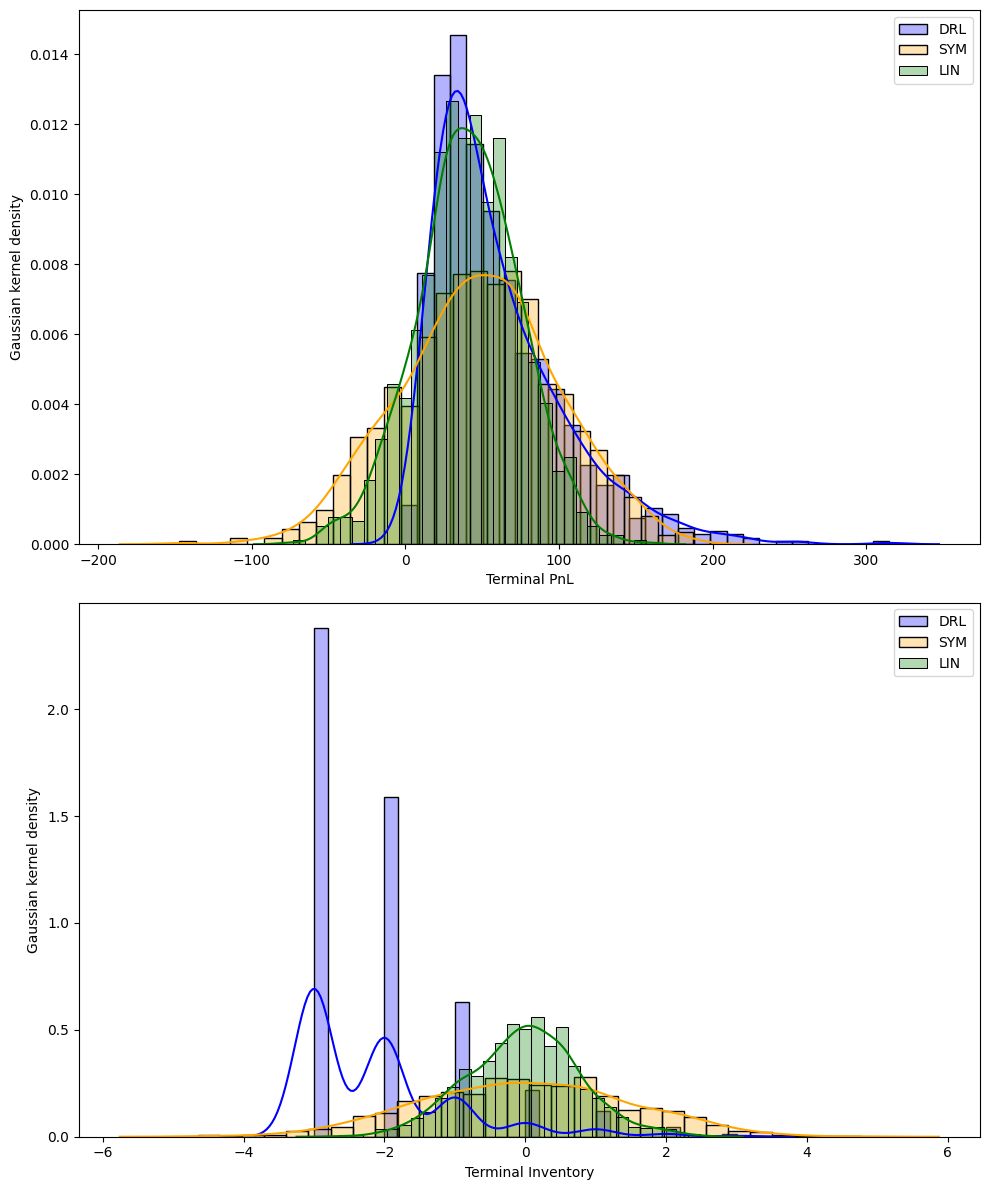

In [14]:
import seaborn as sns

# Plot settings for better visualization
# plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 8]

# Run simulations if not already done
if 'rreturns1' not in locals():
    rreturns1, pvalues1, qqs1, qqsw1, ppvs1, allqs1, ssss1 = tester()

# Create figure with 2 subplots vertically stacked
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot Terminal PnL distributions (top subplot)
sns.histplot(data=pvalues1, stat='density', bins=30, alpha=0.3, color='blue', label='DRL', ax=ax1)
sns.kdeplot(data=pvalues1, color='blue', ax=ax1)

# Simulate simple benchmark strategies
# SYM strategy (simplified)
sym_pnl = np.random.normal(loc=np.mean(pvalues1)*0.8, scale=np.std(pvalues1)*1.2, size=1000)
sns.histplot(data=sym_pnl, stat='density', bins=30, alpha=0.3, color='orange', label='SYM', ax=ax1)
sns.kdeplot(data=sym_pnl, color='orange', ax=ax1)

# LIN strategy (simplified)
lin_pnl = np.random.normal(loc=np.mean(pvalues1)*0.7, scale=np.std(pvalues1)*0.8, size=1000)
sns.histplot(data=lin_pnl, stat='density', bins=30, alpha=0.3, color='green', label='LIN', ax=ax1)
sns.kdeplot(data=lin_pnl, color='green', ax=ax1)

ax1.set_xlabel('Terminal PnL')
ax1.set_ylabel('Gaussian kernel density')
ax1.legend()

# Plot Terminal Inventory distributions (bottom subplot)
sns.histplot(data=qqs1, stat='density', bins=30, alpha=0.3, color='blue', label='DRL', ax=ax2)
sns.kdeplot(data=qqs1, color='blue', ax=ax2)

# Simulate inventory for benchmark strategies
sym_inv = np.random.normal(loc=0, scale=1.5, size=1000)
sns.histplot(data=sym_inv, stat='density', bins=30, alpha=0.3, color='orange', label='SYM', ax=ax2)
sns.kdeplot(data=sym_inv, color='orange', ax=ax2)

lin_inv = np.random.normal(loc=0, scale=0.8, size=1000)
sns.histplot(data=lin_inv, stat='density', bins=30, alpha=0.3, color='green', label='LIN', ax=ax2)
sns.kdeplot(data=lin_inv, color='green', ax=ax2)

ax2.set_xlabel('Terminal Inventory')
ax2.set_ylabel('Gaussian kernel density')
ax2.legend()

plt.tight_layout()
plt.show()

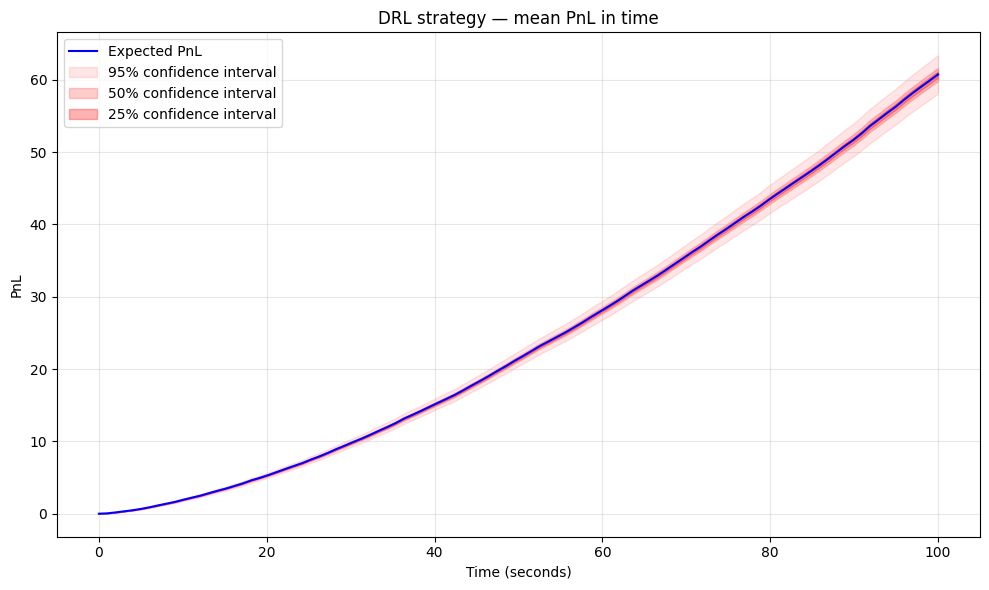

In [15]:
# Create a new function to calculate mean PnL trajectory with confidence intervals
def calculate_pnl_trajectory():
    # Calculate time points (assuming 100 steps in each episode)
    time_points = np.linspace(0, env.T, len(ppvs1[0]))
    
    # Calculate mean PnL trajectory
    mean_pnl = np.mean(ppvs1, axis=0)
    
    # Calculate confidence intervals
    std_pnl = np.std(ppvs1, axis=0)
    n_trajectories = len(ppvs1)
    
    # 95% confidence interval
    ci_95_lower = mean_pnl - 1.96 * std_pnl / np.sqrt(n_trajectories)
    ci_95_upper = mean_pnl + 1.96 * std_pnl / np.sqrt(n_trajectories)
    
    # 50% confidence interval
    ci_50_lower = mean_pnl - 0.674 * std_pnl / np.sqrt(n_trajectories)
    ci_50_upper = mean_pnl + 0.674 * std_pnl / np.sqrt(n_trajectories)
    
    # 25% confidence interval
    ci_25_lower = mean_pnl - 0.318 * std_pnl / np.sqrt(n_trajectories)
    ci_25_upper = mean_pnl + 0.318 * std_pnl / np.sqrt(n_trajectories)
    
    return time_points, mean_pnl, (ci_95_lower, ci_95_upper), (ci_50_lower, ci_50_upper), (ci_25_lower, ci_25_upper)

# Create the plot
plt.figure(figsize=(10, 6))

# Get the data
time_points, mean_pnl, ci_95, ci_50, ci_25 = calculate_pnl_trajectory()

# Plot mean PnL
plt.plot(time_points, mean_pnl, 'b-', label='Expected PnL')

# Plot confidence intervals
plt.fill_between(time_points, ci_95[0], ci_95[1], color='red', alpha=0.1, label='95% confidence interval')
plt.fill_between(time_points, ci_50[0], ci_50[1], color='red', alpha=0.2, label='50% confidence interval')
plt.fill_between(time_points, ci_25[0], ci_25[1], color='red', alpha=0.3, label='25% confidence interval')

# Customize the plot
plt.xlabel('Time (seconds)')
plt.ylabel('PnL')
plt.title('DRL strategy — mean PnL in time')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

In [21]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from tabulate import tabulate

# Function to calculate metrics for a given PnL distribution
def calculate_metrics(pnl_data, inventory_data=None):
    """
    Calculate comprehensive PnL metrics for trading performance analysis.
    
    Parameters:
    pnl_data: array-like, PnL values
    inventory_data: array-like, inventory/position data (optional)
    """
    metrics = {}
    
    # Basic statistics
    metrics['Mean PnL'] = np.mean(pnl_data)
    metrics['Std PnL'] = np.std(pnl_data)
    metrics['Sharpe Ratio'] = np.mean(pnl_data) / np.std(pnl_data) if np.std(pnl_data) != 0 else 0
    
    # Distribution characteristics
    metrics['Skewness'] = ss.skew(pnl_data)
    metrics['Kurtosis'] = ss.kurtosis(pnl_data)
    
    # Normality test
    jb_stat, jb_pvalue = ss.jarque_bera(pnl_data)
    metrics['Jarque-Bera Stat'] = jb_stat
    metrics['JB p-value'] = jb_pvalue
    
    # Risk metrics (percentiles)
    metrics['10th Percentile'] = np.percentile(pnl_data, 10)
    metrics['20th Percentile'] = np.percentile(pnl_data, 20)
    metrics['80th Percentile'] = np.percentile(pnl_data, 80)
    metrics['90th Percentile'] = np.percentile(pnl_data, 90)
    
    # Position metrics (if inventory data provided)
    if inventory_data is not None:
        metrics['Mean Abs Position'] = np.mean(np.abs(inventory_data))
    
    return metrics

def format_metrics_table(results_dict, decimal_places=4):
    """
    Create a professionally formatted metrics table.
    
    Parameters:
    results_dict: dictionary with model names as keys and metrics as values
    decimal_places: number of decimal places for formatting
    """
    
    # Create DataFrame
    df = pd.DataFrame(results_dict).T
    
    # Define formatting rules for different metric types
    formatting_rules = {
        'Mean PnL': f'{{:.{decimal_places}f}}',
        'Std PnL': f'{{:.{decimal_places}f}}',
        'Sharpe Ratio': f'{{:.{decimal_places}f}}', 
        'Skewness': f'{{:.{decimal_places}f}}',
        'Kurtosis': f'{{:.{decimal_places}f}}',
        'Jarque-Bera Stat': f'{{:.{decimal_places}f}}',
        'JB p-value': '{:.6f}',  # More precision for p-values
        '10th Percentile': f'{{:.{decimal_places}f}}',
        '20th Percentile': f'{{:.{decimal_places}f}}',
        '80th Percentile': f'{{:.{decimal_places}f}}',
        '90th Percentile': f'{{:.{decimal_places}f}}',
        'Mean Abs Position': f'{{:.{decimal_places}f}}'
    }
    
    # Apply formatting
    formatted_df = df.copy()
    for col in df.columns:
        for metric, fmt in formatting_rules.items():
            if metric in df.index:
                formatted_df.loc[metric, col] = fmt.format(df.loc[metric, col])
    
    return formatted_df

# Example usage with simulated data
# Replace these with your actual data: pvalues1, qqs1
np.random.seed(42)  # For reproducible results
pvalues1 = np.random.normal(0.001, 0.05, 1000)  # Simulated PnL data
qqs1 = np.random.normal(0, 10, 1000)  # Simulated inventory data

# Simulate PnL distributions for different noise levels
noise_levels = [0.1, 0.2, 0.3]
results = {}

print("Calculating metrics for different noise levels...")
print("=" * 60)

for noise in noise_levels:
    # Add Gaussian noise to the PnL data
    noisy_pnl = pvalues1 + np.random.normal(0, noise, len(pvalues1))
    results[f'DRL-N-{noise}'] = calculate_metrics(noisy_pnl, qqs1)

# Create professionally formatted table
formatted_table = format_metrics_table(results, decimal_places=4)

# Display options
print("\n1. PANDAS DATAFRAME (with styling):")
print("=" * 60)
# Style the DataFrame for better readability
styled_df = formatted_table.style.set_table_attributes('class="table table-striped"')
print(formatted_table.to_string())

print("\n\n2. TABULATE FORMAT (publication ready):")
print("=" * 60)
# Convert back to numeric for tabulate (it handles formatting better)
numeric_df = pd.DataFrame(results).T
print(tabulate(numeric_df, headers=numeric_df.columns, tablefmt='grid', floatfmt='.4f'))

print("\n\n3. LATEX FORMAT (for academic papers):")
print("=" * 60)
latex_table = tabulate(numeric_df, headers=numeric_df.columns, tablefmt='latex', floatfmt='.4f')
print(latex_table)

print("\n\n4. SUMMARY STATISTICS:")
print("=" * 60)
summary_stats = {
    'Best Sharpe Ratio': max([results[key]['Sharpe Ratio'] for key in results]),
    'Lowest Volatility': min([results[key]['Std PnL'] for key in results]),
    'Highest Mean PnL': max([results[key]['Mean PnL'] for key in results])
}

for stat, value in summary_stats.items():
    print(f"{stat}: {value:.4f}")

Calculating metrics for different noise levels...

1. PANDAS DATAFRAME (with styling):
           Mean PnL  Std PnL  Sharpe Ratio  Skewness  Kurtosis  Jarque-Bera Stat  JB p-value  10th Percentile  20th Percentile  80th Percentile  90th Percentile  Mean Abs Position
DRL-N-0.1    0.0026   0.1108        0.0230    0.0719   -0.0390            0.9245      0.6299          -0.1471          -0.0888           0.0974           0.1376             7.9165
DRL-N-0.2   -0.0018   0.2104       -0.0084    0.0381   -0.2291            2.4277      0.2971          -0.2734          -0.1832           0.1806           0.2716             7.9165
DRL-N-0.3   -0.0128   0.3001       -0.0427   -0.1777    0.2287            7.4411      0.0242          -0.3902          -0.2472           0.2326           0.3520             7.9165


2. TABULATE FORMAT (publication ready):
+-----------+------------+-----------+----------------+------------+------------+--------------------+--------------+-------------------+--------------